<table class="table table-bordered">
    <tr>
        <th style="width:250px;">
            <img src='https://bcgriseacademy.com/hs-fs/hubfs/rise2.0_black_logo.png' style="background-color:white; width: 100%; height: 100%; padding: 20px">
        </th>
        <th style="text-align:center;">
            <h1>Mini project - Unsupervised Learning</h1>
            <h3>IBF TFIP</h3>
        </th>
    </tr>
</table>

## Know the context

You are a data analyst working in a retail bank based in the Middle East, where they have been doing traditional mass marketing campaigns for years. The bank is now keen to explore the benefits of running tailored marketing campaigns for their customer base.

## Business problem

The retail bank is facing a couple of challenges:
1. Profitability pressure from reduced utilization by existing customers
2. Increasingly competitive landscape where other banks are running personalized ad campaigns using differentiated products and services

## Project objectives and description

In this discovery phase, the objective is to understand the various segments that exist in the bank's customer base, based on the customers' demographics and utilization patterns.
___

## 1. Initial Setup

In [36]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn import metrics

from sklearn.cluster import AgglomerativeClustering
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

#### (1.1) Read the raw CSV file from the Data folder into pandas

In [2]:
data = pd.read_csv('Data/Data.csv')

#### (1.2) View the first 5 rows of the data

In [3]:
data.head()

,Customer No,Customer Nationality,Customer Age,Account Opening Date,DC Spends,SALARY_FLAG,DR_FLAG,Bill Payment,CC Spends,Monthly Average Balance
0,353446,INDIA,67,17/08/2017,Active,No Salary,No DR,No Bill,No CC,1820.582258
1,99061,PHILIPPINES,71,13/11/2020,Inactive,Salary with Bank,No DR,Active Bill,No CC,94.028387
2,344207,GREECE,56,8/11/2018,Inactive,No Salary,Inactive DR,Inactive Bill,Inactive CC,5020.710000
3,496773,GHANA,40,16/07/2019,Active,Salary with Bank,Active DR,No Bill,Active CC,0.000000
4,39530,PHILIPPINES,57,25/11/2017,Active,No Salary,Inactive DR,Active Bill,No CC,196.214839


___
## 2. Data Exploration

#### (2.1) Find the shape and data types of the dataset

In [4]:
data.shape

(1000, 10)

In [5]:
data.dtypes

Customer No                  int64
Customer Nationality        object
Customer Age                 int64
Account Opening Date        object
DC Spends                   object
SALARY_FLAG                 object
DR_FLAG                     object
Bill Payment                object
CC Spends                   object
Monthly Average Balance    float64
dtype: object

#### (2.2) Convert the columns to the appropriate data type (wherever necessary)
- HINT: Review date related columns

In [6]:
data['Account Opening Date'] = pd.to_datetime(data['Account Opening Date'], format='%d/%m/%Y')

#### (2.3) Check if there are any null values in the columns

In [7]:
data.isna().sum()

Customer No                0
Customer Nationality       0
Customer Age               0
Account Opening Date       0
DC Spends                  0
SALARY_FLAG                0
DR_FLAG                    0
Bill Payment               0
CC Spends                  0
Monthly Average Balance    0
dtype: int64

#### (2.4) For each categorical column, count the number of unique categories
- HINT: Instead of doing it one by one, filter by dtypes that are equal to object, and print the unique count using `.nunique()`

In [8]:
for col in data.columns:
    if data.dtypes[col] == object:
        print(col, data[col].nunique())

Customer Nationality 62
DC Spends 3
SALARY_FLAG 3
DR_FLAG 3
Bill Payment 3
CC Spends 3


#### (2.5) For numerical columns, check the data distributions using appropriate functions and plots (e.g., box plots)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Customer No              1000 non-null   int64         
 1   Customer Nationality     1000 non-null   object        
 2   Customer Age             1000 non-null   int64         
 3   Account Opening Date     1000 non-null   datetime64[ns]
 4   DC Spends                1000 non-null   object        
 5   SALARY_FLAG              1000 non-null   object        
 6   DR_FLAG                  1000 non-null   object        
 7   Bill Payment             1000 non-null   object        
 8   CC Spends                1000 non-null   object        
 9   Monthly Average Balance  1000 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 78.2+ KB


In [10]:
data.describe()

,Customer No,Customer Age,Account Opening Date,Monthly Average Balance
count,1000.000000,1000.000000,1000,1000.000000
mean,245215.013000,49.540000,2019-08-29 02:48:28.800000,3263.444533
min,26.000000,21.000000,2017-01-31 00:00:00,-27.500000
25%,116036.250000,36.000000,2018-04-18 06:00:00,0.000000
50%,239983.000000,50.000000,2019-08-18 00:00:00,15.750000
75%,368319.750000,64.000000,2021-01-08 06:00:00,908.245968
max,499963.000000,77.000000,2022-03-31 00:00:00,372334.503500
std,144281.883775,16.328534,NaN,17576.061302


<Axes: >

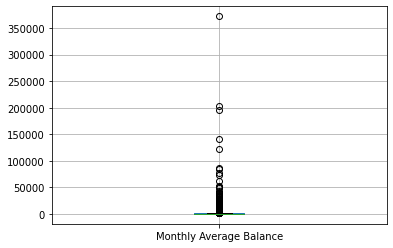

In [11]:
data.boxplot('Monthly Average Balance')

<Axes: >

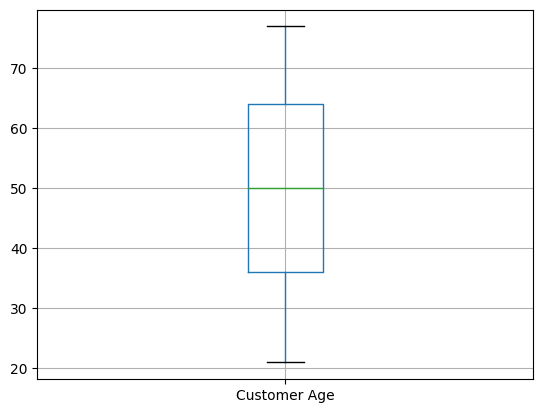

In [12]:
data.boxplot('Customer Age')

**Note**
- As we can see, there are a few very large values (outliers) in the monthly average balance
- Instead of dropping outliers, we will convert them into categories in the next step. 
- Note that dropping outliers is a bad move if we do not know exactly what is going on. For bank accounts, there will definitely be outliers because some customers are more wealthy than the rest. These are not data errors, so should not be dropped just because they are 'inconvenient' for our analysis

___
## 3. Data preprocessing

The goal here is to convert all values to numerical so that record of each customer will be in the form of numeric feature vectors

#### (3.1) Create a new column `Tenure` for the number of months (rounded to nearest integer) since the customer has opened the account
- HINT: The snapshot date is 01 Mar 2022, so you should find the date difference between the snapshot date and the account opening date.
- Feel free to search for 'Pandas - Number of Months Between Two Dates' on StackOverflow for the answer

In [13]:
df_cust = data.copy()

In [14]:
df_cust['Tenure'] = (pd.to_datetime('2022-03-01') - df_cust['Account Opening Date']) / np.timedelta64(1, 'M')

In [15]:
df_cust.head()

,Customer No,Customer Nationality,Customer Age,Account Opening Date,DC Spends,SALARY_FLAG,DR_FLAG,Bill Payment,CC Spends,Monthly Average Balance,Tenure
0,353446,INDIA,67,2017-08-17,Active,No Salary,No DR,No Bill,No CC,1820.582258,53.451613
1,99061,PHILIPPINES,71,2020-11-13,Inactive,Salary with Bank,No DR,Active Bill,No CC,94.028387,15.258065
2,344207,GREECE,56,2018-11-08,Inactive,No Salary,Inactive DR,Inactive Bill,Inactive CC,5020.710000,39.000000
3,496773,GHANA,40,2019-07-16,Active,Salary with Bank,Active DR,No Bill,Active CC,0.000000,30.935484
4,39530,PHILIPPINES,57,2017-11-25,Active,No Salary,Inactive DR,Active Bill,No CC,196.214839,50.225806


#### (3.2) Clean the `Monthly Average Balance` column by converting all negative balance values to 0

In [16]:
df_cust.loc[df_cust['Monthly Average Balance'] < 0, 'Monthly Average Balance'] = 0

#### (3.3) Rather than discarding outliers, we want to group customers into the following categories based on the following monthly average balance deciles. 

- $\ge$95%: 'Very High'
- $\ge$80% - 95%: 'High'
- $\ge$50% - 80%: 'Upper'
- $\lt$50%: 'Normal'

#### Create Python variables to store these decile cutoffs
- HINT: Only need to create 3 variables to indicate Very High, High, and Middle. Use the `.quantile` method

In [17]:
very_high = df_cust['Monthly Average Balance'].quantile(0.95)
high = df_cust['Monthly Average Balance'].quantile(0.8)
middle = df_cust['Monthly Average Balance'].quantile(0.5)

In [18]:
very_high

12083.372146999995

In [19]:
high

1718.8415486000035

In [20]:
middle

15.75

#### (3.4) Using the decile cutoff variables above, create a new column called `Balance Level` by splitting the `Monthly Average Balance` column into 4 categories and giving them the corresponding integer labels: 1, 2, 3, 4 (where 4 corresponds to the very high balance category)
- HINT: Refer to https://stackoverflow.com/questions/44314670/create-rename-categories-with-pandas on how to use `pd.cut`. For the `bins` parameter, suggest to see the lowest value as -0.01 and highest value as 99999999

In [21]:
df_cust['Balance Level'] = pd.cut(df_cust['Monthly Average Balance'], 
                                   bins=[-0.01, middle, high, very_high, 99999999], 
                                   labels=[1, 2, 3, 4],
                                   include_lowest=True)

In [22]:
df_cust

,Customer No,Customer Nationality,Customer Age,Account Opening Date,DC Spends,SALARY_FLAG,DR_FLAG,Bill Payment,CC Spends,Monthly Average Balance,Tenure,Balance Level
0,353446,INDIA,67,2017-08-17,Active,No Salary,No DR,No Bill,No CC,1820.582258,53.451613,3
1,99061,PHILIPPINES,71,2020-11-13,Inactive,Salary with Bank,No DR,Active Bill,No CC,94.028387,15.258065,2
2,344207,GREECE,56,2018-11-08,Inactive,No Salary,Inactive DR,Inactive Bill,Inactive CC,5020.710000,39.000000,3
3,496773,GHANA,40,2019-07-16,Active,Salary with Bank,Active DR,No Bill,Active CC,0.000000,30.935484,1
4,39530,PHILIPPINES,57,2017-11-25,Active,No Salary,Inactive DR,Active Bill,No CC,196.214839,50.225806,2
...,...,...,...,...,...,...,...,...,...,...,...,...
995,66965,INDIA,57,2020-01-02,Active,Salary with Other Bank,Active DR,No Bill,Active CC,205.337742,25.451613,2
996,152560,INDIA,22,2018-02-08,Active,Salary with Other Bank,No DR,Active Bill,No CC,0.000000,47.806452,1
997,268132,INDIA,44,2019-06-15,Inactive,Salary with Other Bank,No DR,Inactive Bill,Active CC,11.649032,31.935484,1
998,79628,INDIA,68,2020-11-08,Inactive,No Salary,Active DR,Active Bill,No CC,0.000000,15.419355,1


#### (3.5) For categorical columns, convert them to numeric format
- Hint: use pandas dummy encoding 

In [23]:
df_cust = pd.get_dummies(df_cust,
                         columns=['DC Spends', 'SALARY_FLAG', 'DR_FLAG', 'Bill Payment', 'CC Spends']
                         )

#### (3.6) Drop columns that are no longer informative for downstream clustering
- `Customer No`, `Customer Nationality`, `Account Opening Date`, `Monthly Average Balance`

In [24]:
df_cust = df_cust.drop(columns = ['Customer No', 'Customer Nationality', 'Account Opening Date', 'Monthly Average Balance'])

In [25]:
df_cust

,Customer Age,Tenure,Balance Level,DC Spends_Active,DC Spends_Inactive,DC Spends_No Spends,SALARY_FLAG_No Salary,SALARY_FLAG_Salary with Bank,SALARY_FLAG_Salary with Other Bank,DR_FLAG_Active DR,DR_FLAG_Inactive DR,DR_FLAG_No DR,Bill Payment_Active Bill,Bill Payment_Inactive Bill,Bill Payment_No Bill,CC Spends_Active CC,CC Spends_Inactive CC,CC Spends_No CC
0,67,53.451613,3,True,False,False,True,False,False,False,False,True,False,False,True,False,False,True
1,71,15.258065,2,False,True,False,False,True,False,False,False,True,True,False,False,False,False,True
2,56,39.000000,3,False,True,False,True,False,False,False,True,False,False,True,False,False,True,False
3,40,30.935484,1,True,False,False,False,True,False,True,False,False,False,False,True,True,False,False
4,57,50.225806,2,True,False,False,True,False,False,False,True,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,57,25.451613,2,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False
996,22,47.806452,1,True,False,False,False,False,True,False,False,True,True,False,False,False,False,True
997,44,31.935484,1,False,True,False,False,False,True,False,False,True,False,True,False,True,False,False
998,68,15.419355,1,False,True,False,True,False,False,True,False,False,True,False,False,False,False,True


#### (3.6) Standardize the numerical values in the dataset
Note: Perform min max scaling

**💬 Checkpoint** 
- Why do we need to standardize the dataset before clustering?

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_cust)
scaled_data = scaler.transform(df_cust)

In [27]:
scaled_data

array([[0.82142857, 0.89496021, 0.66666667, ..., 0.        , 0.        ,
        1.        ],
       [0.89285714, 0.2668435 , 0.33333333, ..., 0.        , 0.        ,
        1.        ],
       [0.625     , 0.65729443, 0.66666667, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.41071429, 0.54111406, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.83928571, 0.26949602, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.25      , 0.83872679, 0.        , ..., 0.        , 0.        ,
        1.        ]])

___
## 4. K-Means Clustering
The objective is to
- Find the most appropriate k value using the Elbow method
- Calculate and store the silhouette coefficient values

#### (4.1) Create a baseline k-means model with `k=3` and `random_state=0` by fitting on the scaled data

In [28]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(scaled_data)

#### (4.2) Obtain the inertia value and silhouette score of this model
HINT: For silhouette score, you will need to first get predictions with `fit_predict`

In [29]:
kmeans.inertia_

2915.435252490949

In [30]:
y_pred = kmeans.fit_predict(scaled_data)
silhouette_score(scaled_data, y_pred)

0.14055908652242674

#### (4.3) Repeat the above two steps but for the range of k values from 2 to 12. Save the inertia scores and silhouette scores in separate dictionaries

In [31]:
sse = {}
sil_scores = {}
for k in range(2, 12):
    model = KMeans(n_clusters=k).fit(scaled_data)
    sse[k] = model.inertia_
    y_pred = model.predict(scaled_data)
    sil_scores[k] = silhouette_score(scaled_data, y_pred)

#### (4.4) Use the Elbow method (along with showing the plot) to determine the optimal number of clusters. 

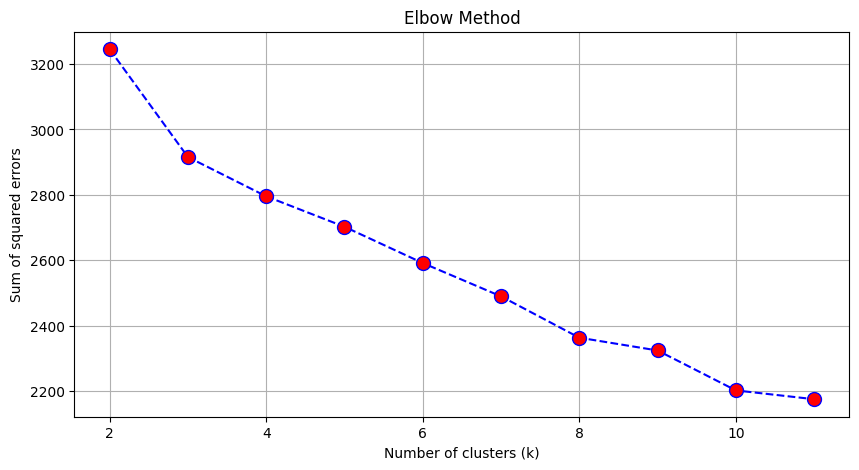

In [32]:
plt.figure(figsize=(10, 5)) # Set the size of the plot

plt.plot(list(sse.keys()), list(sse.values()),
         color='blue', linestyle='dashed', 
         marker='o', markerfacecolor='red', markersize=10)
plt.grid(True)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared errors')
plt.title('Elbow Method')

plt.show()

#### (4.5) Use the Silhouette method (along with showing the plot) to determine the optimal number of clusters. 
- HINT: This part is NOT about generating the silhouette analysis graphs. Instead, repeat the code in Step 4.4, but instead of using inertia values, use the silhouette scores that you have already saved from Step 4.3

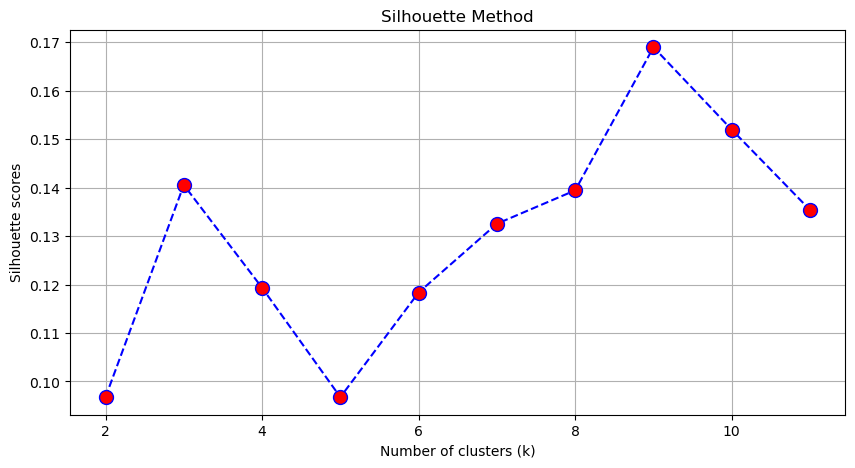

In [33]:
plt.figure(figsize=(10, 5)) # Set the size of the plot

plt.plot(list(sil_scores.keys()), list(sil_scores.values()),color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.grid(True)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette scores')
plt.title('Silhouette Method')

plt.show()

#### (4.6) What can we summarize from the elbow and silhouette plots, and what is the optimal cluster number you would choose?

- The elbow plot is not conclusive in telling us the optimal number of clusters since there is no clear elbow observed, though there appears to be a slight elbow at k=3
- From the silhouette plot, we can see that the optimal number of clusters is 8 and 9 (where silhouette scores are the highest), though the score for k=3 is pretty good too
- Overall, we can go with k=3

___
## 5. Hierarchical clustering

#### (5.1) Using the scaled data we created earlier, produce a dendrogram with hierarchical clustering

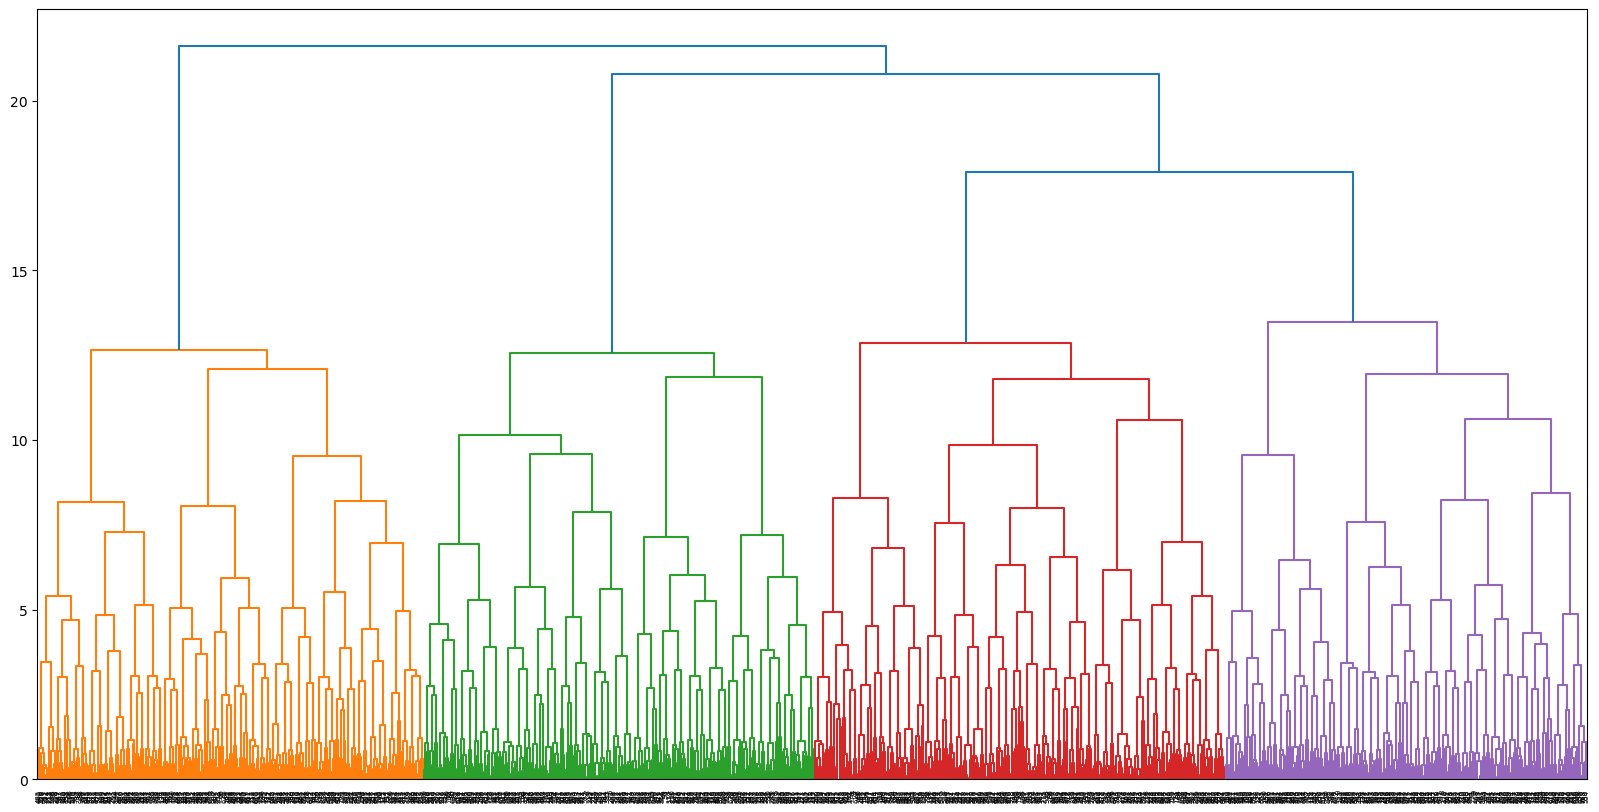

In [34]:
mergings = linkage(scaled_data, method='ward')

plt.figure(figsize=(20, 10))
dendrogram(mergings)
plt.show()

#### (5.2) What can we summarize from the dendrogram, and what is the optimal cluster number you would choose?

k=4 appears to be the optimal number of clusters

#### (5.3) Using the optimal number of clusters above, create a hierarchical clustering model
- Use `AgglomerativeClustering`

In [35]:
h_model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')

#### (5.4) Calculate the silhouette score

In [36]:
y_pred = h_model.fit_predict(scaled_data)
silhouette_score(scaled_data, y_pred)

0.07728484090933517

In [39]:
from sklearn.metrics import silhouette_samples, silhouette_score

For n_clusters = 2 The average silhouette_score is : 0.09667507344729506
For n_clusters = 3 The average silhouette_score is : 0.14055908652242674
For n_clusters = 4 The average silhouette_score is : 0.11063040120371155
For n_clusters = 5 The average silhouette_score is : 0.09483721671673791
For n_clusters = 6 The average silhouette_score is : 0.1066881322652726


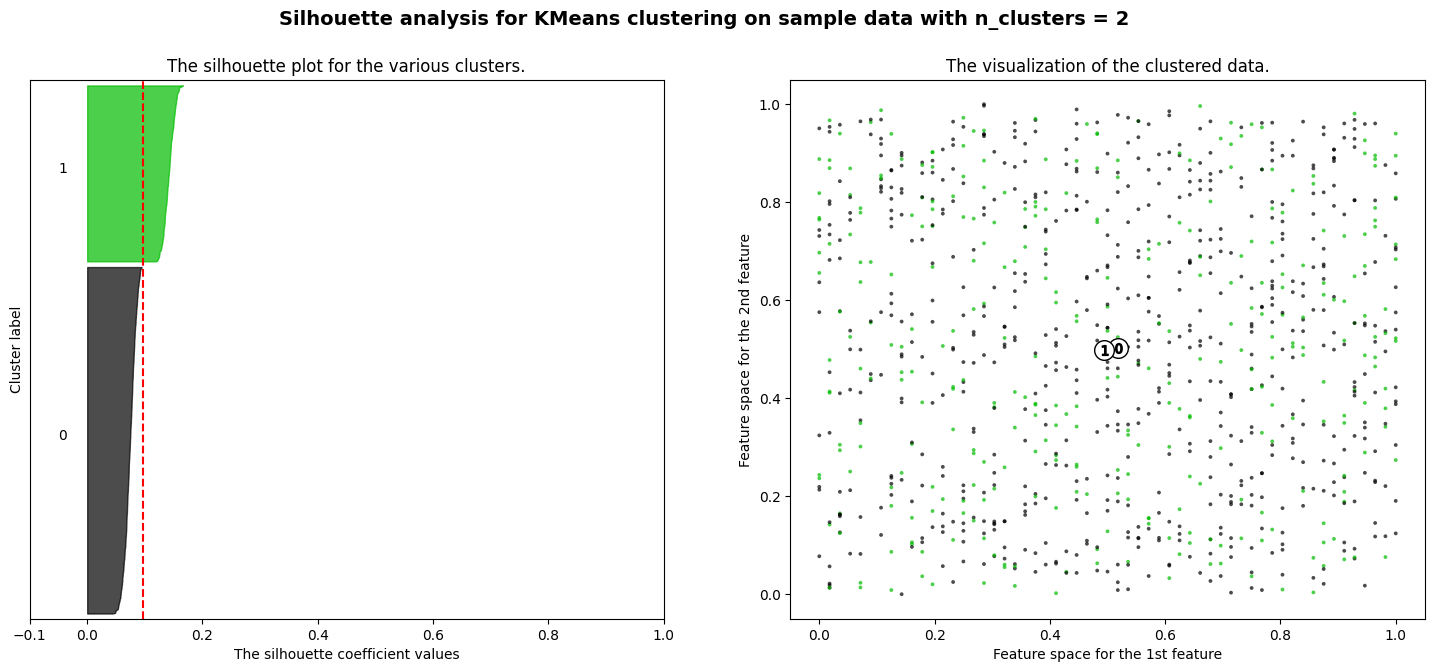

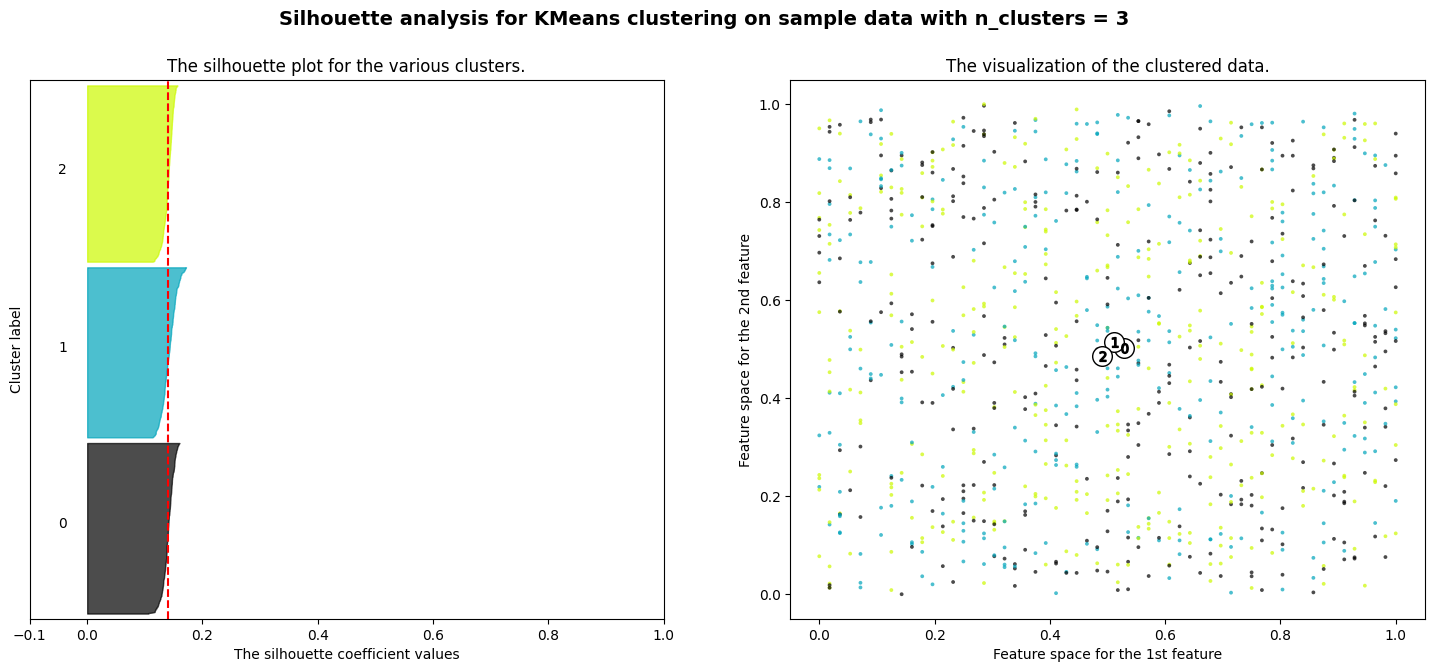

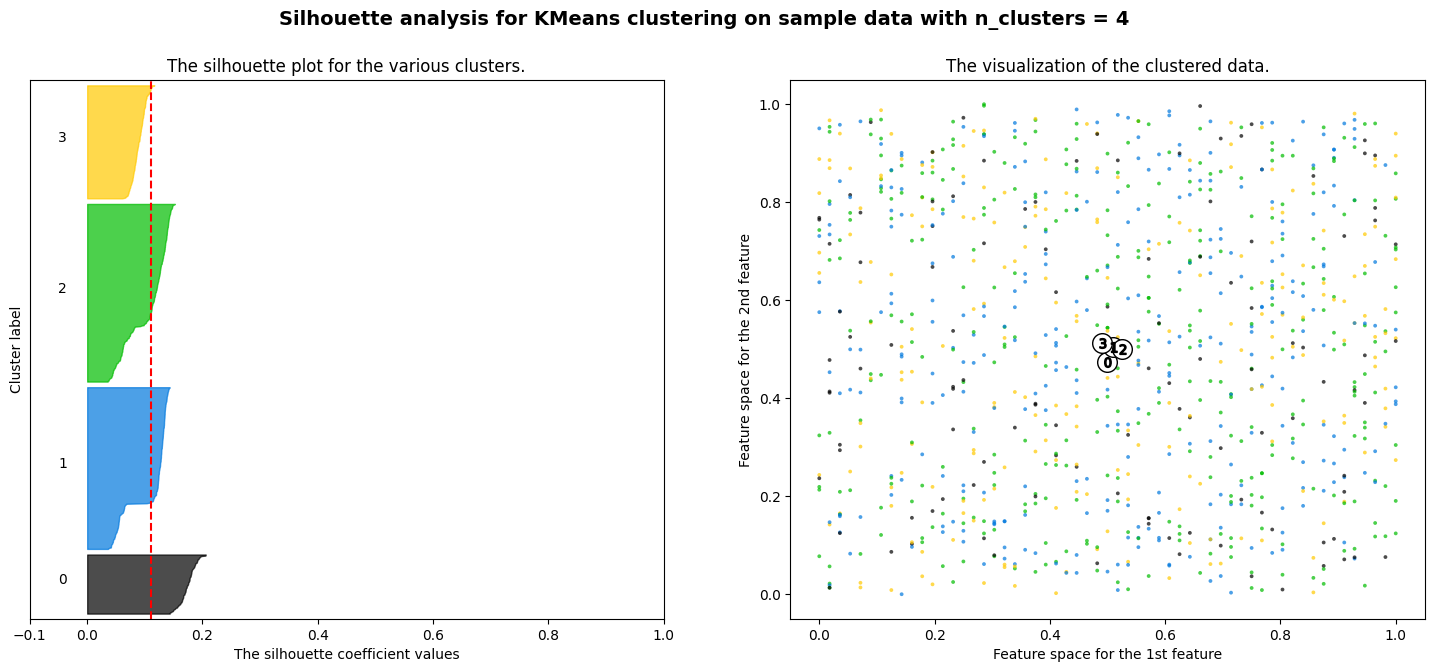

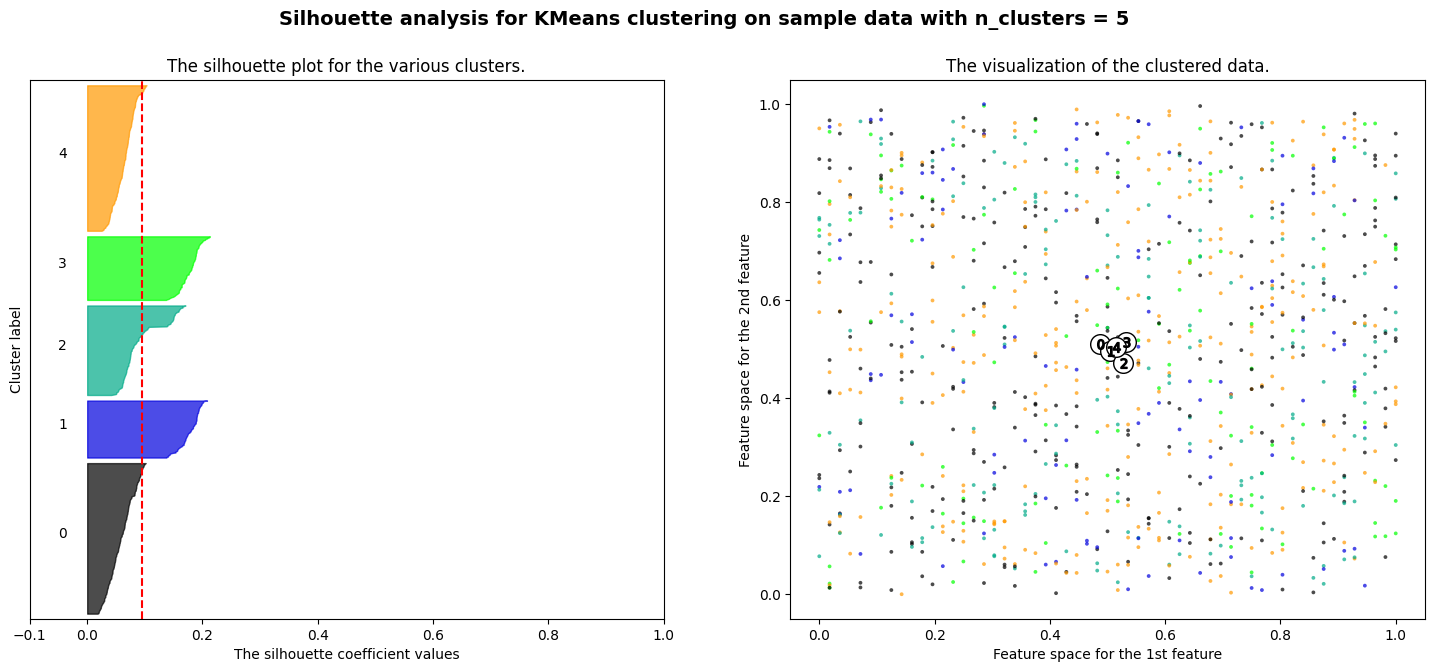

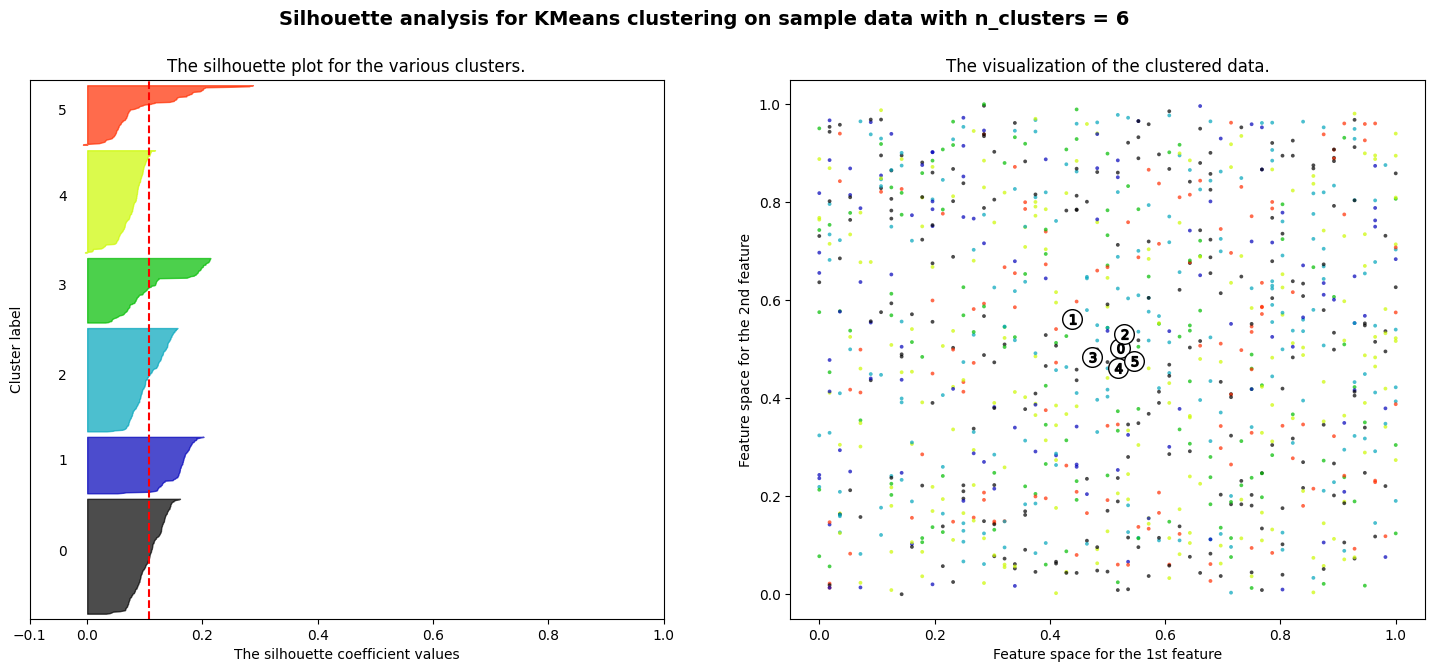

In [40]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

___
## 6. Generating cluster labels

#### (6.1) Compare the silhouette score of k-means model (with k=3) and hierarchical clustering model (with k=4), and determine which is the ideal model to use
- Recall that the higher the silhouette score, the better the separation of clusters
- We use k=3 for k-means even though the optimal number appears to be 9, because a smaller number of clusters is easier to interpret and work with for an initial clustering analysis

Silhouette score of k-means model (k=3): **0.1405**  
Silhouette score of hierarchical clustering model (k=4): **0.0772**

#### (6.2) Using the model with the higher silhouette score, generate the predicted labels for each customer in the dataset, and save it the output array in a variable called `labels`
- HINT: Use `fit_predict`

In [37]:
labels = kmeans.fit_predict(scaled_data)

#### (6.3) Append the `labels` array as a column (with the same name) to the processed dataframe from Step 3.6, so that each customer now has an assigned label

In [38]:
df_cust['labels'] = labels

In [39]:
df_cust['labels'].value_counts()

2    341
0    330
1    329
Name: labels, dtype: int64

#### (6.4) Append the `labels` array as a column (with the same name) to the original dataset

In [40]:
data['labels'] = labels

___
## 7. Extracting Insights
Now that we have assigned each customer to the relevant cluster labels, it is time to better understand how the clusters differ in terms of profile

#### (7.1) Compare the customer ages across the clusters
- HINT: Sample code: `df.groupby(['labels'])['Column name'].mean().round(2)`

In [41]:
df_cust.groupby(['labels'], sort=True)['Customer Age'].mean().round(2)

labels
0    50.64
1    49.60
2    48.42
Name: Customer Age, dtype: float64

#### (7.2) Compare the average monthly balance across the clusters
- HINT: Use the right dataset that contains the column required

In [42]:
data.groupby(['labels'], sort=True)['Monthly Average Balance'].mean().round(2)

labels
0    3913.62
1    2470.21
2    3399.56
Name: Monthly Average Balance, dtype: float64

#### (7.3) Compare the tenure across the clusters
- HINT: Use the right dataset that contains the column required

In [43]:
df_cust.groupby(['labels'], sort=True)['Tenure'].mean().round(2)

labels
0    30.13
1    30.92
2    29.15
Name: Tenure, dtype: float64

___